# Housing Price Prediction

The goal of this project is to predict house prices based on 81 features as a part of Kaggle Competition. The dataset used for this competition can be found here.

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

## `1` Preprocessing 

### `1.1` Importing useful libraries

In [ ]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from scipy import stats
from scipy.special import boxcox1p


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

### `1.2`  Importing Dataset


In [ ]:
# importing the data

train = pd.read_csv('/content/drive/MyDrive/Kaggle Data Nomads/Project 1_house prices/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle Data Nomads/Project 1_house prices/test.csv')

In [ ]:
#  few rows of the training Dataset
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [ ]:
# few rows of the test dataset
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

## `1.3` Processing the dataset

In [ ]:
# concatenating both train and test dataset to produce whole_dataset
whole_dataset  = pd.concat([train,test], axis=0)

# splitting the dataset into features and labels
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

# mean and standard deviation of the labels and standardisation
mean = y.mean()
std = y.std()
y= (y - y.mean())/y.std()

In [ ]:
# dummy_X is the copy of X (excluding SalePrice) for making transformations
dummy_X = X.copy() 
dummy_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# null values in whole dataset

whole_dataset.isnull().sum()[whole_dataset.isnull().sum()>0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

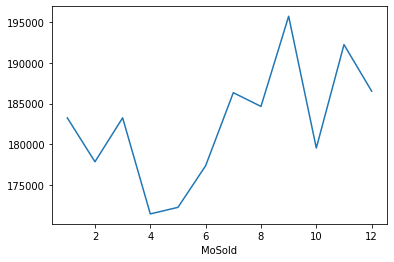

In [ ]:
# distribution of label (SalePrice) with respect to the month in which it was sold
pd.concat([dummy_X, train['SalePrice']], axis =1).groupby('MoSold').mean()['SalePrice'].plot()

In [ ]:
def missing_values(dummy_X):

    '''
        treatment of missing values and feature engineering
        
        input : original features
        output : cleaned dataframe of features
    '''
    # replacing null values with median 
    dummy_X['LotFrontage'] = dummy_X['LotFrontage'].apply(lambda x: dummy_X['LotFrontage'].median() if pd.isnull(x) else x)
    
    # replacing null values 
    dummy_X['Alley'].fillna('No Alley', inplace=True)
    dummy_X['MasVnrType'].fillna('None', inplace=True)
    dummy_X['MasVnrArea'].fillna(0, inplace=True)
    dummy_X['BsmtQual'].fillna('No', inplace=True)
    dummy_X['BsmtCond'].fillna('No', inplace=True)
    dummy_X['BsmtExposure'].fillna('No', inplace=True)
    dummy_X['BsmtFinType1'].fillna('No', inplace=True)
    dummy_X['BsmtFinType2'].fillna('No', inplace=True)
    dummy_X['Electrical'].fillna('FuseA', inplace=True)
    dummy_X['FireplaceQu'].fillna('No', inplace=True)
    dummy_X['GarageType'].fillna('No', inplace=True)
    dummy_X['GarageYrBlt'].fillna(1980.0, inplace=True)
    dummy_X['GarageFinish'].fillna('No', inplace=True)
    dummy_X['GarageCars'].fillna(0, inplace=True)
    dummy_X['GarageArea'].fillna(0, inplace=True)
    dummy_X['GarageQual'].fillna('No', inplace=True)
    dummy_X['GarageCond'].fillna('No', inplace=True)
    dummy_X['PoolQC'].fillna('No', inplace=True)
    dummy_X['Fence'].fillna('No', inplace=True)
    dummy_X['MiscFeature'].fillna('No', inplace=True)
    dummy_X['YrSold'].fillna(2008.0, inplace=True)
    dummy_X['YearRemodAdd'].fillna(1994.0, inplace=True)
    dummy_X['YrSold'].fillna(2008.0, inplace=True)
    dummy_X['MSZoning'].fillna('RL', inplace=True)
    dummy_X['Utilities'].fillna('AllPub', inplace=True)
    
    # for these columns replacing null values with mode value
    cols  = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath','HouseArea',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'SaleType','Neighborhood']
    for col in cols:
        dummy_X[col].fillna(dummy_X[col].mode()[0], inplace = True)

    
    # Engineering new features
    dummy_X['Age'] = dummy_X['YrSold']-dummy_X['YearRemodAdd']
    dummy_X['HouseArea'] = dummy_X['1stFlrSF'] + dummy_X['2ndFlrSF'] + dummy_X['GrLivArea'] +dummy_X['TotalBsmtSF']
    dummy_X['PorchArea'] = dummy_X['OpenPorchSF'] + dummy_X['EnclosedPorch'] + dummy_X['3SsnPorch'] + dummy_X['ScreenPorch']
    dummy_X['GarageAge'] = dummy_X['YrSold']- dummy_X['GarageYrBlt']

    # Dropping few features which are not useful after engineering new features
    dummy_X.drop(['YrSold','YearRemodAdd','1stFlrSF','2ndFlrSF','GrLivArea','TotalBsmtSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','YearBuilt','GarageYrBlt','Id'], axis=1, inplace = True)
    
    # dummy_X['OverallCond'] = dummy_X['OverallCond'].astype('object')
    # dummy_X['OverallQual'] = dummy_X['OverallQual'].astype('object')
    return dummy_X

In [ ]:

def label_encode(data):
    
    '''
        function to apply label encoding to columns
    '''

    # label encoding the columns in this list
    col = ['HeatingQC', 'BsmtFinType1', 'Exterior1st', 'MasVnrType', 'Exterior2nd',
       'MSZoning',  'HouseStyle', 'LotShape',
       'SaleCondition', 'BsmtExposure','GarageCond', 'GarageQual', 'CentralAir', 'SaleType', 'Electrical',
       'PavedDrive', 'BsmtCond', 'Fence', 'Condition1', 'RoofStyle',
       'BsmtFinType2', 'LandContour', 'BldgType', 'Functional', 'ExterCond',
       'Alley', 'Heating', 'Condition2', 'LotConfig', 'RoofMatl',
       'MiscFeature', 'PoolQC', 'LandSlope', 'Street', 'Utilities']
  
    for c in col:

        lbl = LabelEncoder() 
        lbl.fit(list(data[c].values))
        lbl_copy = lbl 
        data[c] = lbl.transform(list(data[c].values))
        



    return data, lbl_copy

  

  

In [ ]:
def one_hot_encode(data):
      '''
          function to one-hot-encode some categorical columns like 'Neighborhood'
      '''
      list_1 = ['MeadowV', 'IDOTRR', 'BrDale', 'BrkSide', 'Edwards', 'OldTown','Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel']
      list_2 = ['SawyerW','NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr', 'Crawfor', 'ClearCr','Somerst', 'Veenker', 'Timber']
      list_3 = ['StoneBr', 'NridgHt', 'NoRidge']

      def func_neighborhood(val):
        '''
            function to replace values according to the list given above
        '''

        val=str(val)

        if val in list_1:

          val = 'Low'
        elif val in list_2:
          val = 'Medium'
        elif val in list_3:
          val = 'High'

        return val

      data['Neighborhood']  = data['Neighborhood'].apply(func_neighborhood)

      data=pd.get_dummies(data, drop_first=True)

      return data


In [ ]:
def normalisation(data):

  '''
  function to apply standard scaler on features
  '''
  scaler = StandardScaler()
  scaler.fit(data)

  return scaler

In [ ]:
def feature_selection(data):
    
  '''
  function to select few features out of 79 based on Lasso Regression
  '''

  feature_sel_model = SelectFromModel(Lasso(alpha=0.018, random_state=0))
  feature_sel_model.fit(data, y)
  selected_feat = data.columns[(feature_sel_model.get_support())]
  return selected_feat

In [ ]:
# applying missing value treatment and adding new features to whole dataset
whole_dataset = missing_values(whole_dataset)

# partition into numeric and categorical columns
numeric_cols = [col for col in whole_dataset.columns if whole_dataset[col].dtype!='object']
categorical_cols = [col for col in whole_dataset.columns if whole_dataset[col].dtype=='object']

# applying label encode and one-hot-encode on whole-dataset
whole_dataset, lbl = label_encode(whole_dataset)
whole_dataset = one_hot_encode(whole_dataset)

# applying box cox on features to make it more like a normal distribution
for feat in numeric_cols:
  if feat == 'Id':
    continue
  whole_dataset[feat] = boxcox1p(whole_dataset[feat], 0.15)

# applying normalisation on the whole dataset
scaler = normalisation(whole_dataset)
whole_dataset = pd.DataFrame(scaler.transform(whole_dataset), columns=whole_dataset.columns)

In [ ]:
# whole dataset after thee changes
whole_dataset

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age,HouseArea,PorchArea,GarageAge,Neighborhood_Low,Neighborhood_Medium,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf
0,0.369814,-0.042157,-0.065014,-0.142360,0.064249,0.05533,0.746669,0.316671,-0.018512,0.588555,-0.21626,-0.046258,-0.009816,-0.419174,1.031721,0.680801,-0.449532,-0.482926,-0.116923,0.742788,0.750334,-1.267151,1.178840,0.376461,0.333532,0.624607,-0.529329,0.800337,0.353536,-0.35802,-0.546412,-0.103206,-0.880324,0.26829,0.30129,-0.115984,1.130512,-0.251371,0.810002,1.261463,...,-0.185769,-1.798779,0.319311,0.204967,0.535683,-0.698943,0.310583,0.329449,-0.948409,-1.021121,1.248312,-0.110163,1.407698,-1.266462,-0.856372,1.109798,-0.130664,-0.061503,-0.041423,-0.176308,1.189282,-0.168941,-0.885568,-0.156748,1.239377,-1.023223,-0.161278,-0.584867,1.027440,-0.126535,-0.504386,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,1.612222,-0.853371
1,-1.091580,-0.042157,0.595976,0.110415,0.064249,0.05533,0.746669,0.316671,-0.018512,-0.658174,-0.21626,-1.190557,-0.009816,-0.419174,-0.536817,0.023436,1.957283,-0.482926,-0.116923,-0.507795,-0.657990,0.384843,-0.779163,0.376461,0.333532,-1.158500,-1.424268,0.974460,0.353536,-0.35802,-0.131136,-0.103206,-0.880324,0.26829,0.30129,-0.115984,-0.832992,3.881509,0.810002,-0.763816,...,-0.185769,-0.268408,0.319311,0.204967,0.182763,0.645163,-0.091270,-1.396319,0.417265,-1.021121,1.248312,-0.110163,-0.710380,0.789601,1.167717,-0.901065,-0.130664,-0.061503,-0.041423,-0.176308,1.189282,-0.168941,-0.885568,-0.156748,-0.806857,0.977304,-0.161278,-0.584867,-0.973292,-0.126535,1.982610,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,1.612222,-0.853371
2,0.369814,-0.042157,0.076737,0.431443,0.064249,0.05533,-1.381776,0.316671,-0.018512,0.588555,-0.21626,-0.046258,-0.009816,-0.419174,1.031721,0.680801,-0.449532,-0.482926,-0.116923,0.742788,0.750334,-1.267151,1.078600,0.376461,0.333532,-0.266947,-0.529329,0.611098,0.353536,-0.35802,0.168081,-0.103206,-0.880324,0.26829,0.30129,-0.115984,1.130512,-0.251371,0.810002,1.261463,...,-0.185769,0.965748,0.319311,0.204967,0.715254,-0.588790,0.475397,0.129744,-0.737425,-1.021121,1.248312,-0.110163,1.407698,-1.266462,-0.856372,1.109798,-0.130664,-0.061503,-0.041423,-0.176308,1.189282,-0.168941,-0.885568,-0.156748,1.239377,-1.023223,-0.161278,-0.584867,-0.973292,-0.126535,1.982610,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,1.612222,-0.853371
3,0.597523,-0.042157,-0.313927,0.099975,0.064249,0.05533,-1.381776,0.316671,-0.018512,-1.904903,-0.21626,-0.046258,-0.009816,-0.419174,1.031721,0.680801,-0.449532,-0.482926,-0.116923,1.055433,1.313664,0.384843,-0.779163,0.376461,-2.737700,0.624607,-1.424268,0.235331,0.353536,-0.35802,0.329970,-0.103206,0.267617,0.26829,0.30129,-0.115984,1.130512,-0.251371,-1.027605,-0.763816,...,-0.185769,-1.798779,0.319311,-3.505415,-0.458481,0.778429,0.242988,1.345772,-0.648383,-1.021121,1.248312,-0.110163,-0.710380,0.789601,-0.856372,-0.901065,-0.130664,-0.061503,-0.041423,-0.176308,-0.840843,-0.168941,1.129219,-0.156748,1.239377,-1.023223,-0.161278,1.709792,-0.973292,-0.126535,-0.504386,-1.200265,-0.111745,

In [ ]:
# splitting train and test dataset from whole-dataset as it was before
train = whole_dataset[whole_dataset.index < 1460]
X_train = train.drop('SalePrice', axis=1)
y_train = y
test = whole_dataset[whole_dataset.index >= 1460]
X_test = test.drop('SalePrice', axis=1)

# applying feature selection on training data 
selected_feat = feature_selection(X_train)
X_train = train[selected_feat]

In [ ]:
# number of selected features
len(selected_feat)

40

In [ ]:
#seeing attributes of the SalePrice column
y_train.describe()

count    1.460000e+03
mean     1.102999e-16
std      1.000000e+00
min     -1.838074e+00
25%     -6.412965e-01
50%     -2.255870e-01
75%      4.163867e-01
max      7.226343e+00
Name: SalePrice, dtype: float64

In [ ]:
# processed test dataframe
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,...,MiscVal,MoSold,SaleType,SaleCondition,SalePrice,Age,HouseArea,PorchArea,GarageAge,Neighborhood_Low,Neighborhood_Medium,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_No,BsmtQual_TA,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf
1460,-1.091580,-1.561354,0.595976,0.498239,0.064249,0.05533,0.746669,0.316671,-0.018512,0.588555,-0.21626,-1.190557,-0.009816,-0.419174,-0.536817,-0.719243,0.448293,-0.482926,-0.116923,0.742788,0.750334,0.384843,-0.779163,0.376461,0.333532,0.624607,0.813079,0.592561,-2.002561,2.061794,-0.165530,-0.103206,1.415558,0.26829,0.30129,-0.115984,-0.832992,-0.251371,-1.027605,-0.763816,...,-0.185769,0.094109,0.319311,0.204967,NaN,1.064246,-1.199742,0.723919,0.843074,0.979316,-0.801082,-0.110163,-0.710380,0.789601,1.167717,-0.901065,-0.130664,-0.061503,-0.041423,-0.176308,-0.840843,-0.168941,1.129219,-0.156748,-0.806857,0.977304,-0.161278,-0.584867,1.027440,-0.126535,-0.504386,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,-0.620262,1.171824
1461,-1.091580,-0.042157,0.636227,0.926849,0.064249,0.05533,-1.381776,0.316671,-0.018512,-1.904903,-0.21626,-0.046258,-0.009816,-0.419174,-0.536817,0.023436,0.448293,1.953824,-0.116923,1.055433,1.031999,-1.267151,0.874909,0.376461,0.333532,0.624607,-1.424268,0.942906,0.353536,-0.358020,0.119735,-0.103206,1.415558,0.26829,0.30129,-0.115984,-0.832992,-0.251371,-1.027605,1.261463,...,9.238779,0.094109,0.319311,0.204967,NaN,1.121063,0.078631,0.050852,0.900803,0.979316,-0.801082,-0.110163,-0.710380,0.789601,1.167717,-0.901065,-0.130664,-0.061503,-0.041423,-0.176308,-0.840843,-0.168941,1.129219,-0.156748,1.239377,-1.023223,-0.161278,-0.584867,1.027440,-0.126535,-0.504386,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,-0.620262,1.171824
1462,0.369814,-0.042157,0.345193,0.860971,0.064249,0.05533,-1.381776,0.316671,-0.018512,0.588555,-0.21626,-0.046258,-0.009816,-0.419174,1.031721,-0.719243,-0.449532,-0.482926,-0.116923,0.742788,0.750334,0.384843,-0.779163,0.376461,0.333532,0.624607,-0.529329,0.860106,0.353536,-0.358020,-0.602131,-0.103206,0.267617,0.26829,0.30129,-0.115984,-0.832992,-0.251371,0.810002,1.261463,...,-0.185769,-1.182872,0.319311,0.204967,NaN,-0.119871,0.239816,0.022128,-0.299985,-1.021121,1.248312,-0.110163,-0.710380,0.789601,-0.856372,1.109798,-0.130664,-0.061503,-0.041423,-0.176308,1.189282,-0.168941,-0.885568,-0.156748,-0.806857,0.977304,-0.161278,-0.584867,-0.973292,-0.126535,1.982610,0.833150,-0.111745,-0.260878,-0.071870,-0.603340,-0.238417,-0.240018,-0.620262,-0.853371
1463,0.369814,-0.042157,0.514190,0.187882,0.064249,0.05533,-1.381776,0.316671,-0.018512,0.588555,-0.21626,-0.046258,-0.009816,-0.419174,1.031721,0.023436,0.448293,-0.482926,-0.116923,0.742788,0.750334,-1.267151,0.158353,0.376461,0.333532,0.624607,-0.529329,0.718266,0.353536,-0.358020,-0.040225,-0.103206,-0.880324,0.26829,0.30129,-0.115984,-0.832992,-0.251371,0.810002,1.261463,...,-0.185769,0.094109,0.319311,0.204967,NaN,-0.119871,0.198336,0.050852,-0.360045,-1.021121,1.248312,-0.110163,-0.710380,0.789601,-0.856372,1.109798,-0.130664,-0.061503,-0.041423,-0.176308,-0.840843,-0.168941,1.129219,-0.156748,1.239377,-1.023223,-0.161278,1.709792,-0.973292,-0.126535,-0.504386,0.833150,-0.111745,-0.260878,-0.0718

In [ ]:
# I also tried sklearn's SelectKBest and f_regression to select out best features
selector = SelectKBest(f_regression, 28)

# KFold cross validation
kf = KFold(10)

## `2` Applying Machine Learning with various models

In [ ]:
# Linear Regression

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

In [ ]:
# get best features using Recursive Feature Elimnation
model = RFECV(LinearRegression(),cv=10)
model.fit(X_train,y_train)
optimized_columns = X_train.columns[model.support_]

In [ ]:
# Random Forest Model
model_rf  = RandomForestRegressor((n_estimators=2500, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=1, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None))


# Gradient Boosting Model
model_gb = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=, 
                                   loss='huber', random_state =5)

# XGBoost Regressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=2, 
                             min_child_weight=1.5, n_estimators=2000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=2, min_child_weight=1.5, missing=None, n_estimators=2000,
             n_jobs=1, nthread=-1, objective='reg:linear', random_state=7,
             reg_alpha=0.464, reg_lambda=0.8571, scale_pos_weight=1, seed=None,
             silent=1, subsample=0.5213, verbosity=1)

In [ ]:
# applying cross validation and checking scores on different models
n_folds=5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_gb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_rf)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# filling some null values in test dataset
X_test = X_test[selected_feat]
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())
X_test['GarageAge'] = X_test['GarageAge'].fillna(X_test['GarageAge'].median())



In [3]:
# getting predictions from the selected model and scaling them back
predictions = pd.Series(model.predict(X_test))
predictions = predictions*std + mean

In [ ]:
# displaying the predictions
predictions

0       129109.578125
1       160268.234375
2       180927.359375
3       190714.062500
4       189630.843750
            ...      
1454     85375.546875
1455     89511.093750
1456    174119.281250
1457    114139.343750
1458    204833.406250
Length: 1459, dtype: float32

In [ ]:
# mean of all predictions
predictions.mean()

179622.609375

In [ ]:
# making submission_new dataframe
test_id = test['Id']
submission_new = pd.concat([test_id,predictions], axis=1)
submission_new.rename(columns  = {0:'SalePrice'}, inplace=True)

In [ ]:
submission_new

,Id,SalePrice
0,1461,129109.578125
1,1462,160268.234375
2,1463,180927.359375
3,1464,190714.062500
4,1465,189630.843750
...,...,...
1454,2915,85375.546875
1455,2916,89511.093750
1456,2917,174119.281250
1457,2918,114139.343750


In [ ]:
submission_new.to_csv('submission_housing.csv', index=False)